## Clustering

## Description

In this project I will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

I will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [1]:
pathToFile = r"pathToFile"
fileName = 'fileName.txt'

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [3]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [4]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [5]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [7]:
data.shape

(140256, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [9]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the 2 days of 2012 for the first 2 clients

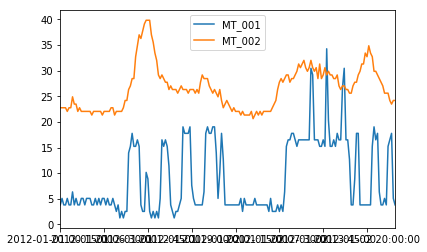

In [10]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [11]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [12]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [13]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [14]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [15]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [16]:
data['hour'] = data.index.map(lambda x: x[11:])

In [17]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [18]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [19]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

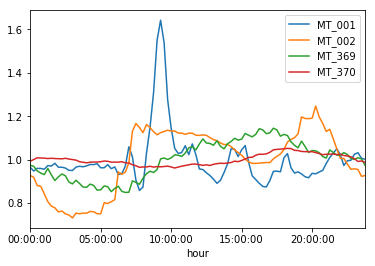

In [20]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [21]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format

In [22]:
X.shape

(349, 96)

## Number of Clusters:

a. Determine a convenient number of clusters based on _intertia_ and based on _silhouette_. 

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster 
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)

### a.  determine number of clusters based on intertia & silhouette

In [26]:
def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2   

In [27]:
inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

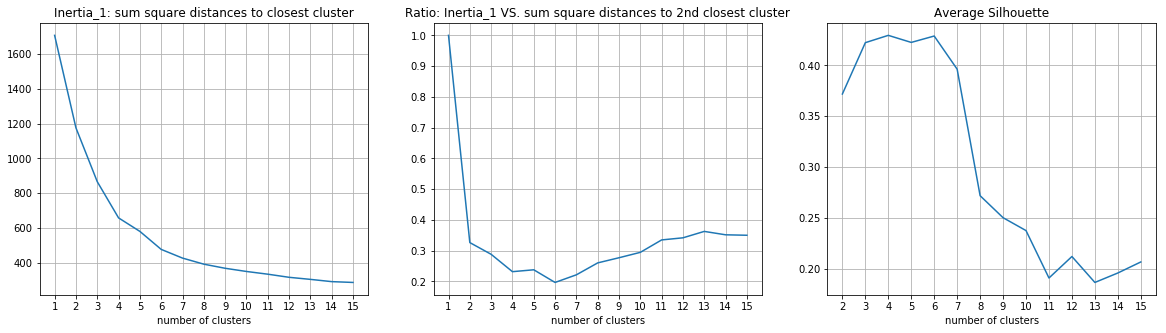

In [28]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

####  optimal value of  k
In the first case (inertias) what we are looking for is an "elbow" in the graph. Here is tricky to find the best value of  __k__  since it is not so obvious.

When looking at the ration between inertia_1 and inertia_2, one looks for a minimum value, which in this case corresponds with  __k=6__.

The silhouette gives higher values for best clusterings, so what we look for is a maximum, which happens again at  __k=6__.

So __k=6__ has been chosen for the number of clusters.

---

### b. Make a plot for each cluster

In [98]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)

In [100]:
centroid = kmeans.cluster_centers_
t_centroid= np.array(centroid.T) #transpose the array

In [101]:
t_centroid

array([[ 0.67739432,  0.64571855,  1.08615607,  0.11746873,  0.96736479,
         1.03163126],
       [ 0.6586004 ,  0.57225928,  1.04007873,  0.11450392,  0.96441968,
         4.33742713],
       [ 0.64088421,  0.51938738,  1.0050012 ,  0.11457565,  0.9613496 ,
         3.45273332],
       [ 0.62970256,  0.44315417,  0.97208302,  0.11471911,  0.96669245,
         1.80168719],
       [ 0.61920389,  0.41852016,  0.94352988,  0.1156755 ,  0.96324601,
         1.71606058],
       [ 0.61647704,  0.37099088,  0.91657794,  0.11593851,  0.96301771,
         1.6241923 ],
       [ 0.60290872,  0.35740342,  0.89207824,  0.11608196,  0.95763218,
         1.63243294],
       [ 0.59695603,  0.35281722,  0.87003795,  0.11675144,  0.95553528,
         1.51831613],
       [ 0.5910871 ,  0.34848478,  0.84832245,  0.11620151,  0.95533626,
         1.51309118],
       [ 0.59460235,  0.33578386,  0.82195425,  0.11691881,  0.95794671,
         1.50087243],
       [ 0.58578988,  0.32787899,  0.79582893,  0.

In [109]:
labels = kmeans.labels_
unique, counts = np.unique(labels, return_counts=True) #count the occurrences of each label
dict(zip(unique, counts))

{0: 200, 1: 34, 2: 79, 3: 1, 4: 31, 5: 4}

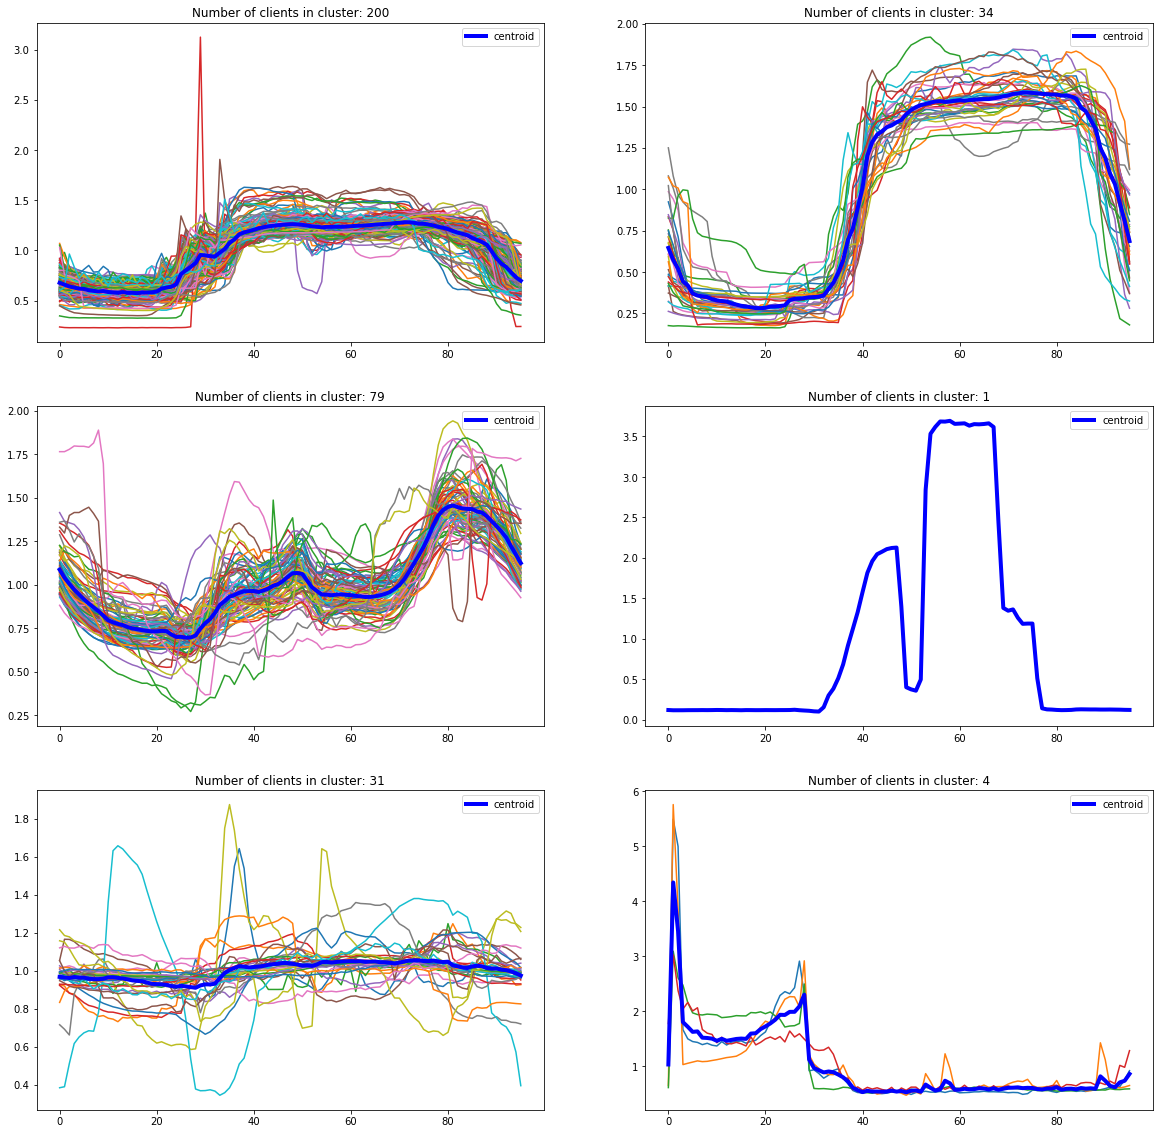

In [125]:
plt.figure(figsize= (20,20))

for i in range (len(centroid)):

    for index, label in enumerate (labels):
        
        if label == i:

            plt.subplot(3,2,i+1)

            plt.plot (X[index].T)
    
            
    plt.subplot(3,2,i+1)
    plt.title ("Number of clients in cluster: {}".format(counts[i]))
    plt.plot(t_centroid[:,i], linewidth =4, c= 'blue', label="centroid")
    plt.legend()   
    

plt.show()

_according to the graphs, kmeans assign a cluster to every points, so outlier are forced to belong to a cluster._

---

## Analyze data for one single client:


First create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [142]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96]/np.mean(oneClient[J*96:(J+1)*96]))]) 

In [143]:
X = np.array(X)

In [144]:
X.shape

(730, 96)

----

### a. Determine the optimal value for k-means

In [145]:
inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

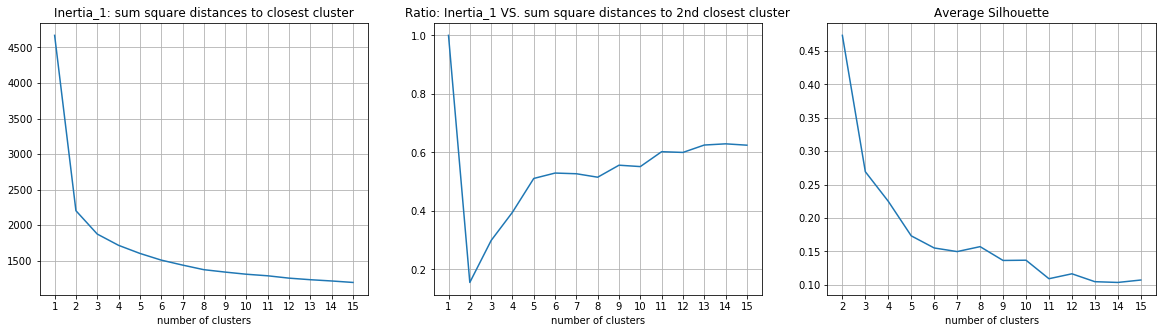

In [146]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

optimal value of k : __k=2__

----

### b. What are the clusters represent?

In [147]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

In [168]:
centroids= kmeans.cluster_centers_
t_centroid= np.array(centroids.T) #transpose the array

In [150]:
labels = kmeans.labels_

In [152]:
unique, counts = np.unique(labels, return_counts=True) #count the occurrences of each label
dict(zip(unique, counts))

{0: 519, 1: 211}

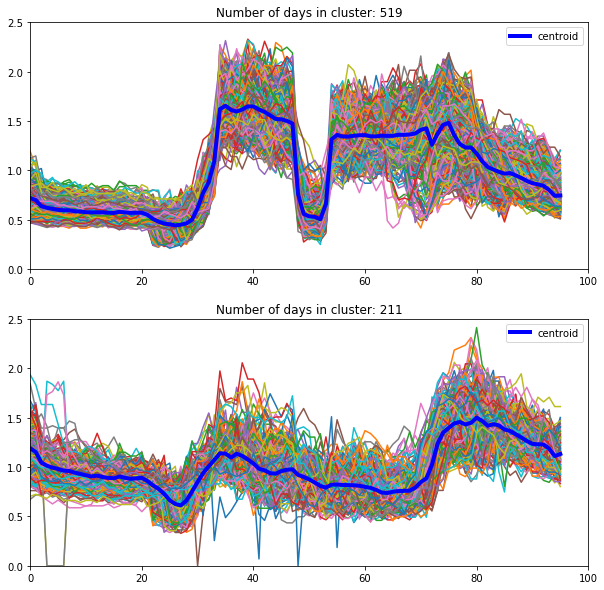

In [170]:
plt.figure(figsize= (10,10))

for i in range (2):

    for index, label in enumerate (labels):
        
        if label == i:

            plt.subplot(2,1,i+1)

            plt.plot (X[index].T)
    
            
    plt.subplot(2,1,i+1)
    plt.title ("Number of days in cluster: {}".format(counts[i]))
    plt.plot(t_centroid[:,i], linewidth =4, c= 'blue', label="centroid")
    plt.legend()   
    plt.axis([0,100,0,2.5])

plt.show()

---

#### generates a list of all the days in the two years 2013-2014

In [171]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The distribution of weekdays in each cluster:

In [239]:
from itertools import compress

days= []
for index, label in enumerate (labels):
    days.append(daysyear[index][:3])
days_cluster1= list(compress(days,labels))

unique1, counts1 = np.unique(days_cluster1, return_counts=True) 

print("distribution of weekdays in cluster_1 (211 days):")
dict_c1= dict(zip(unique1, counts1))
dict_c1

distribution of weekdays in cluster_1 (211 days):


{'fri': 11, 'mon': 12, 'sat': 52, 'sun': 104, 'thu': 11, 'tue': 11, 'wed': 10}

In [240]:
days_cluster0 = list(compress(days,[not i for i in labels]))
unique0, counts0 = np.unique(days_cluster0, return_counts=True) 

print("distribution of weekdays in cluster_0 (519 days):")
dict_c0= dict(zip(unique0, counts0))
dict_c0

distribution of weekdays in cluster_0 (519 days):


{'fri': 93, 'mon': 92, 'sat': 52, 'thu': 93, 'tue': 94, 'wed': 95}

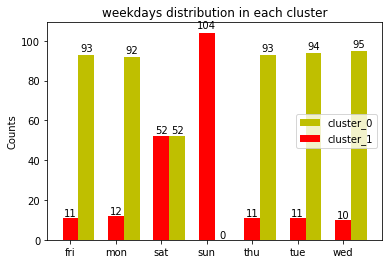

In [268]:
dict_c0_7days= {'fri': 93, 'mon': 92, 'sat': 52, 'sun': 0, 'thu': 93, 'tue': 94, 'wed': 95}
#bar chart:

fig, ax = plt.subplots()
c1 = ax.bar(np.arange(7), dict_c1.values(), width=0.35, color='r',tick_label =dict_c1.keys())

c0 = ax.bar(np.arange(7) + 0.35, dict_c0_7days.values(), width=0.35, color='y')

# add some text for labels, title
ax.set_ylabel('Counts')
ax.set_title('weekdays distribution in each cluster')


ax.legend((c0[0], c1[0]), ('cluster_0', 'cluster_1'), loc= "center right")


def autolabel(c):
    """
    Attach a text label above each bar displaying its height
    """
    for i in c:
        height = i.get_height()
        ax.text(i.get_x() + i.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(c0)
autolabel(c1)

plt.show()

________________
_let's take a closer look at the dates in cluster 1: (except Sundays):_

In [236]:
daysyear_label = list(zip(labels,daysyear))
sat_c1= []
for label,day in daysyear_label:
    if day[:3] == 'sat'and label ==1:
        sat_c1.append(day)

print("All Saturdays in Cluster 1: ")
sat_c1

All Saturdays in Cluster 1: 


['sat-2013-01-05',
 'sat-2013-01-12',
 'sat-2013-01-19',
 'sat-2013-01-26',
 'sat-2013-02-02',
 'sat-2013-02-09',
 'sat-2013-02-16',
 'sat-2013-02-23',
 'sat-2013-03-02',
 'sat-2013-03-09',
 'sat-2013-03-16',
 'sat-2013-03-23',
 'sat-2013-03-30',
 'sat-2013-04-06',
 'sat-2013-04-13',
 'sat-2013-04-20',
 'sat-2013-04-27',
 'sat-2013-05-04',
 'sat-2013-05-11',
 'sat-2013-05-18',
 'sat-2013-05-25',
 'sat-2013-06-01',
 'sat-2013-06-15',
 'sat-2013-06-22',
 'sat-2013-07-06',
 'sat-2013-08-03',
 'sat-2013-08-10',
 'sat-2013-08-17',
 'sat-2013-08-24',
 'sat-2013-08-31',
 'sat-2013-09-07',
 'sat-2013-09-28',
 'sat-2013-10-05',
 'sat-2013-12-14',
 'sat-2013-12-28',
 'sat-2014-01-04',
 'sat-2014-02-22',
 'sat-2014-03-01',
 'sat-2014-03-15',
 'sat-2014-03-22',
 'sat-2014-04-05',
 'sat-2014-04-19',
 'sat-2014-04-26',
 'sat-2014-05-03',
 'sat-2014-05-10',
 'sat-2014-06-28',
 'sat-2014-08-09',
 'sat-2014-08-16',
 'sat-2014-08-23',
 'sat-2014-08-30',
 'sat-2014-09-13',
 'sat-2014-12-27']

In [238]:
wd_c1= []
for label,day in daysyear_label:
    if day[:3] != 'sat'and day[:3] != 'sun' and label ==1:
        wd_c1.append(day)


print("All weekdays(except weekends) in Cluster 1: ")   
wd_c1

All weekdays(except weekends) in Cluster 1: 


['tue-2013-01-01',
 'tue-2013-02-12',
 'fri-2013-03-29',
 'mon-2013-04-01',
 'thu-2013-04-25',
 'wed-2013-05-01',
 'thu-2013-05-02',
 'fri-2013-05-03',
 'mon-2013-06-10',
 'mon-2013-08-12',
 'tue-2013-08-13',
 'wed-2013-08-14',
 'thu-2013-08-15',
 'fri-2013-08-16',
 'mon-2013-08-19',
 'tue-2013-08-20',
 'wed-2013-08-21',
 'thu-2013-08-22',
 'fri-2013-08-23',
 'mon-2013-08-26',
 'tue-2013-08-27',
 'wed-2013-08-28',
 'thu-2013-08-29',
 'fri-2013-08-30',
 'mon-2013-12-23',
 'tue-2013-12-24',
 'wed-2013-12-25',
 'thu-2013-12-26',
 'fri-2013-12-27',
 'mon-2013-12-30',
 'tue-2013-12-31',
 'wed-2014-01-01',
 'tue-2014-03-04',
 'mon-2014-04-21',
 'fri-2014-04-25',
 'thu-2014-05-01',
 'fri-2014-05-02',
 'mon-2014-06-09',
 'tue-2014-06-10',
 'thu-2014-08-14',
 'fri-2014-08-15',
 'mon-2014-08-18',
 'tue-2014-08-19',
 'wed-2014-08-20',
 'thu-2014-08-21',
 'fri-2014-08-22',
 'mon-2014-08-25',
 'tue-2014-08-26',
 'wed-2014-08-27',
 'thu-2014-08-28',
 'fri-2014-08-29',
 'mon-2014-12-08',
 'wed-2014-1

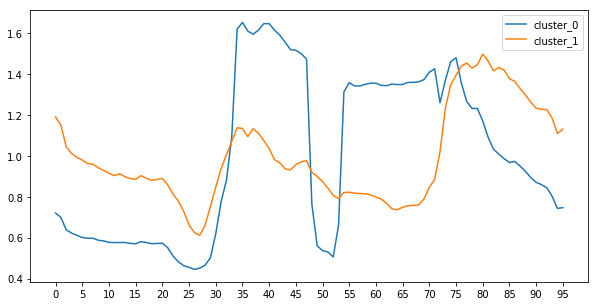

In [235]:
#centroids:
plt.figure(figsize = (10,5))
plt.plot(t_centroid[:,0], label = "cluster_0")
plt.plot(t_centroid[:,1], label = "cluster_1")
plt.legend()
plt.xticks(range(0,100,5))
plt.show()

### Conclusion:

- According to the bar chart of the distribution of weekdays in each cluster, cluster_0 represents workdays and half of saturdays in 2013 and 2014. While cluster_1 illustrates the weekends and holidays.


- Looking at the graph of centriods' time Series of each cluster, the client consumes more electricity during the day (7am - 9pm) on days belong to cluster_0 (workdays), except about an hour around 12pm.
    In contrast, The most eletricity consumption is observed after about 6pm in cluster_1.